In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_11516\252527164.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# download the dataset
cdata = torchvision.datasets.CIFAR10(root='CFAR',download=True)

Files already downloaded and verified


In [4]:
# Check the data parameters
print(f"Data shape: {cdata.data.shape} -> 50000 images of 32x32 pixels with 3 color channels")
print(f"Data labels: {cdata.class_to_idx}")
print(f"{np.unique(cdata.targets)} -> Zero-indexed")
print(f"Data contains nans: {np.isnan(cdata.data).any()} -> Great!")

Data shape: (50000, 32, 32, 3) -> 50000 images of 32x32 pixels with 3 color channels
Data labels: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
[0 1 2 3 4 5 6 7 8 9] -> Zero-indexed
Data contains nans: False -> Great!


# Plot some figures

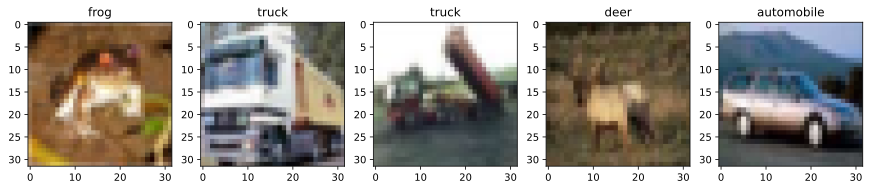

In [5]:
## PLot some figures

plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(cdata.data[i, :, :, :])
    plt.title(f"{list(cdata.class_to_idx.keys())[cdata.targets[i]]}")

plt.show()

# Normalize data

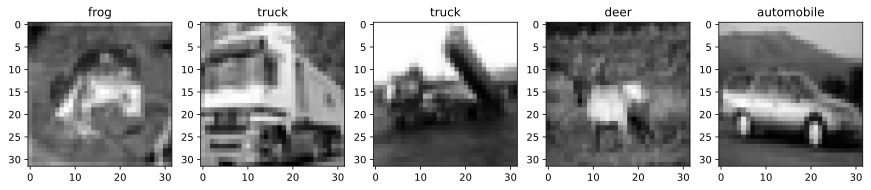

In [9]:
## Normalize data
# Grayscale
datags = np.sum(cdata.data, axis=3).astype(float)

# [0, 255] -> [0, 1]
data = datags / np.max(datags)

plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(datags[i, :, :], cmap='gray')
    plt.title(f"{list(cdata.class_to_idx.keys())[cdata.targets[i]]}")

plt.show()

# Convert to pytorch format

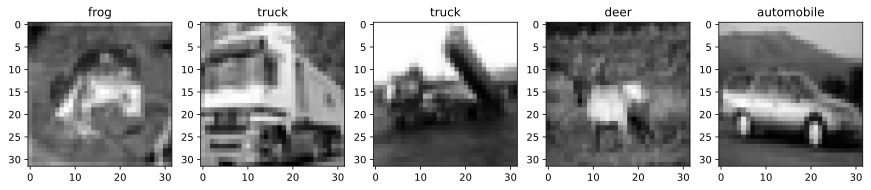

Labels shape: torch.Size([50000])
Data shape: torch.Size([50000, 1, 32, 32])


In [12]:
# labelsT = torch.tensor(np.vstack(cdata.targets)).long()
labelsT = torch.tensor(cdata.targets).long()
dataT   = torch.tensor(data).reshape([50000,1,32,32]).float()

plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(dataT[i, 0, :, :], cmap='gray')
    plt.title(f"{list(cdata.class_to_idx.keys())[labelsT[i]]}")

plt.show()

print(f"Labels shape: {labelsT.shape}")
print(f"Data shape: {dataT.shape}")

# Split testing set

In [13]:
# Reserve 10% of original data for testing set
n_test = int(round(dataT.shape[0] * 0.1))

testset_random_idxs = np.random.choice(np.arange(dataT.shape[0]), size=n_test, replace=False)
testset_mask = np.zeros(dataT.shape[0]).astype(bool)
testset_mask[testset_random_idxs] = True

testset_dataT = dataT[testset_mask]
testset_labelsT = labelsT[testset_mask]

# Remove testset from original dataset
train_dev_dataT = dataT[~testset_mask]
train_dev_labelsT = labelsT[~testset_mask]

print(f"Testset size: {n_test}")
print(f"Labels shape: {testset_dataT.shape}")
print(f"Data shape: {testset_labelsT.shape}")
print("")
print(f"Dataset size: {train_dev_dataT.shape[0]}")
print(f"Labels shape: {train_dev_dataT.shape}")
print(f"Data shape: {train_dev_labelsT.shape}")

# train_dev_dataT  = dataT
# train_dev_labels = labelsT

Testset size: 5000
Labels shape: torch.Size([5000, 1, 32, 32])
Data shape: torch.Size([5000])

Dataset size: 45000
Labels shape: torch.Size([45000, 1, 32, 32])
Data shape: torch.Size([45000])


# Enhance data

In [21]:
from copy import deepcopy

# Add image permutations
custom_transform = nn.Sequential(
    # T.AutoAugment(T.AutoAugmentPolicy.CIFAR10)      # Cheating a bit?
    T.RandomVerticalFlip(p=.5),
    T.RandomRotation(180)
)

# Double the data, half is enhanced
dataE = deepcopy(train_dev_dataT)
dataE = custom_transform(dataE)
dataE = torch.cat([train_dev_dataT, dataE]).float()
labelsE = torch.cat([train_dev_labelsT] * 2).long()

print(f"Dataset size: {dataE.shape[0]}")
print(f"Labels shape: {dataE.shape}")
print(f"Data shape: {labelsE.shape}")
# dataE = dataT
# labelsE = labelsT

Dataset size: 90000
Labels shape: torch.Size([90000, 1, 32, 32])
Data shape: torch.Size([90000])


# Create dataloaders

In [22]:
# Step 2: use scikitlearn to split the data
train_data, dev_data, train_labels,dev_labels = train_test_split(dataE, labelsE, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
dev_data  = TensorDataset(dev_data, dev_labels)

# Step 4: translate into dataloader objects
batchsize    = 128
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader   = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0])

# Create CNN

In [33]:
def get_conv_layer_output_size(input_size: (int, int), padding: (int, int), kernel_size: (int, int), stride: (int, int), pool_size: (int, int)) -> (int, int):
    dim0 = int((((input_size[0] + (2 * padding[0]) - kernel_size[0]) / stride[0]) + 1) / pool_size[0])
    dim1 = int((((input_size[1] + (2 * padding[1]) - kernel_size[1]) / stride[1]) + 1) / pool_size[1])
    return dim0, dim1


class MyCIFAR10CNN(nn.Module):
    def __init__(self,printtoggle):
        super().__init__()

        # print toggle
        self.print = printtoggle

        ### -------------- feature map layers -------------- ###
        # first convolution layer
        self.conv1  = nn.Conv2d(1,8,3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(8) # input the number of channels in this layer
        # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

        # second convolution layer
        self.conv2  = nn.Conv2d(8,32,3,padding=1)
        self.bnorm2 = nn.BatchNorm2d(32) # input the number of channels in this layer
        # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

        # third convolution layer
        self.conv3  = nn.Conv2d(32,128,3,padding=1)
        self.bnorm3 = nn.BatchNorm2d(128) # input the number of channels in this layer
        # output size: (8+2*1-3)/1 + 1 = 8/2 = 4 (/2 b/c maxpool)

        # fourth convolution layer
        self.conv4  = nn.Conv2d(128,512,3,padding=1)
        self.bnorm4 = nn.BatchNorm2d(512) # input the number of channels in this layer
        # output size: (4+2*1-3)/1 + 1 = 4/2 = 2 (/2 b/c maxpool)

        ### -------------- linear decision layers -------------- ###
        self.fc1 = nn.Linear(2*2*self.conv4.out_channels, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self,x):

        if self.print: print(f'Input: {list(x.shape)}')

        # first block: convolution -> maxpool -> batchnorm -> relu
        x = F.max_pool2d(self.conv1(x),2)
        x = F.leaky_relu(self.bnorm1(x))
        x = F.dropout(x, p=0.25, training=self.training)
        if self.print: print(f'First CPR block: {list(x.shape)}')

        # second block: convolution -> maxpool -> batchnorm -> relu
        x = F.max_pool2d(self.conv2(x),2)
        x = F.leaky_relu(self.bnorm2(x))
        x = F.dropout(x, p=0.25, training=self.training)
        if self.print: print(f'Second CPR block: {list(x.shape)}')

        # third block: convolution -> maxpool -> batchnorm -> relu
        x = F.max_pool2d(self.conv3(x),2)
        x = F.leaky_relu(self.bnorm3(x))
        x = F.dropout(x, p=0.25, training=self.training)
        if self.print: print(f'Third CPR block: {list(x.shape)}')

        # fourth block: convolution -> maxpool -> batchnorm -> relu
        x = F.max_pool2d(self.conv4(x),2)
        x = F.leaky_relu(self.bnorm4(x))
        x = F.dropout(x, p=0.25, training=self.training)
        if self.print: print(f'Third CPR block: {list(x.shape)}')

        # reshape for linear layer
        nUnits = x.shape.numel()/x.shape[0]
        x = x.view(-1,int(nUnits))
        if self.print: print(f'Vectorized: {list(x.shape)}')

        # linear layers
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        if self.print: print(f'Final output: {list(x.shape)}')

        return x

def create_the_net(print: bool = False):
    # create the model instance and copy to device (GPU)
    net = MyCIFAR10CNN(print).to(device)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.0001)

    return net,lossfun,optimizer

In [34]:
# test the model with one batch
net,lossfun,optimizer = create_the_net(True)

X,y = next(iter(train_loader))
yHat = net(X.to(device)).cpu()

# check size of output
print('\nOutput size:')
print(yHat.shape)
print(y.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [128, 1, 32, 32]
First CPR block: [128, 8, 16, 16]
Second CPR block: [128, 32, 8, 8]
Third CPR block: [128, 128, 4, 4]
Third CPR block: [128, 512, 2, 2]
Vectorized: [128, 2048]
Final output: [128, 10]

Output size:
torch.Size([128, 10])
torch.Size([128])
 
Loss:
tensor(2.3184, grad_fn=<NllLossBackward0>)


# Function to train the model

In [35]:
# a function that trains the model
def function2trainTheModel(net=None):

    # number of epochs
    numepochs = 15

    numbatches = len(list(train_loader))

    # create a new model, or use exisiting net
    net_,lossfun,optimizer = create_the_net()
    if net is None:
        net = net_

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss  = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    devAcc   = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        print(f"Starting epoch {epochi}...")

        # loop over training data batches
        net.train()
        batchLoss = torch.zeros(numbatches)
        batchAcc  = torch.zeros(numbatches)
        batch_idx = 0
        for X,y in train_loader:
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and Accuracy from this batch
            batchLoss[batch_idx] = loss
            batchAcc[batch_idx] = torch.mean((torch.argmax(yHat,axis=1) == y).float())
            batch_idx += 1
        # end of batch loop...

        # and get average losses and accuracies rates across the batches
        trainLoss[epochi] = torch.mean(batchLoss)
        trainAcc[epochi]  = 100*torch.mean(batchAcc)

        ### dev performance
        net.eval()
        X,y = next(iter(dev_loader)) # extract X,y from test dataloader
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat, y)

        # get loss and accuracy rate from the devset
        devLoss[epochi] = loss
        devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float())

        print(f"Training... Epoch [{epochi+1}/{numepochs}] done. Accuracy: {devAcc[epochi]:.02f}%")

    # end epochs

    # function output
    return trainLoss,devLoss,trainAcc,devAcc,net

# Train the model

In [36]:
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

Starting epoch 0...
Training... Epoch [1/15] done. Accuracy: 34.70%
Starting epoch 1...
Training... Epoch [2/15] done. Accuracy: 35.28%
Starting epoch 2...
Training... Epoch [3/15] done. Accuracy: 50.33%
Starting epoch 3...
Training... Epoch [4/15] done. Accuracy: 58.42%
Starting epoch 4...
Training... Epoch [5/15] done. Accuracy: 55.89%
Starting epoch 5...
Training... Epoch [6/15] done. Accuracy: 58.71%
Starting epoch 6...
Training... Epoch [7/15] done. Accuracy: 56.56%
Starting epoch 7...
Training... Epoch [8/15] done. Accuracy: 60.24%
Starting epoch 8...
Training... Epoch [9/15] done. Accuracy: 55.69%
Starting epoch 9...
Training... Epoch [10/15] done. Accuracy: 64.69%
Starting epoch 10...
Training... Epoch [11/15] done. Accuracy: 66.24%
Starting epoch 11...
Training... Epoch [12/15] done. Accuracy: 63.81%
Starting epoch 12...
Training... Epoch [13/15] done. Accuracy: 65.36%
Starting epoch 13...
Training... Epoch [14/15] done. Accuracy: 63.89%
Starting epoch 14...
Training... Epoch 

In [ ]:
# Transfer learning, if required
trainLoss_,devLoss_,trainAcc_,devAcc_, net = function2trainTheModel(net)

# Concatenate data
trainLoss = torch.cat((trainLoss, trainLoss_))
devLoss = torch.cat((devLoss, devLoss_))
trainAcc = torch.cat((trainAcc, trainAcc_))
devAcc = torch.cat((devAcc, devAcc_))


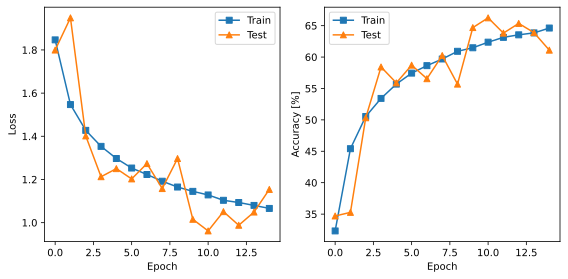

In [37]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(trainLoss.detach(), 's-', label="Train")
plt.plot(devLoss.detach(), '^-', label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(trainAcc.detach(), 's-', label="Train")
plt.plot(devAcc.detach(), '^-', label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

plt.tight_layout()
plt.show()

# Evaluate test set

In [38]:
net.eval()
yHat = net.cpu()(testset_dataT)

In [41]:
print(100 * torch.mean((torch.argmax(yHat, axis=1) == testset_labelsT).float()).item())

63.66000175476074
